# Setup

In [31]:
import logging
import math

import torch
import torch.nn.functional as F
from torch import nn

In [32]:
from sympy import Dummy, lambdify, srepr, symbols
from sympy.core.function import AppliedUndef
from sympy.core.sympify import sympify
from sympy.physics import mechanics
from sympy.physics.vector import Vector
from sympy.printing.printer import Printer

from models import sympy2torch

import torch


def pendulum_energy(n=1, lengths=1, masses=1, include_gpe=True, include_ke=True):
    # Generalized coordinates and velocities
    # (in this case, angular positions & velocities of each mass) 
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))

    # mass and length
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))

    # gravity and time symbols
    g, t = symbols('g,t')

    #--------------------------------------------------
    # Step 2: build the model using Kane's Method

    # Create pivot point reference frame
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    Origin = P
    P.set_vel(A, 0)

    gravity_direction = -A.x

    # lists to hold particles, forces, and kinetic ODEs
    # for each pendulum in the chain
    particles = []
    forces = []

    gpe = []
    ke = []

    cartVel = 0.0
    cartPos = 0.0

    for i in range(n):
        # Create a reference frame following the i^th mass
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)

        # Create a point in this reference frame
        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)

        # Create a new particle of mass m[i] at this point
        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)

        # Calculate the cartesian position and velocity:
        # cartPos += l[i] * q[i]
        pos = Pi.pos_from(Origin)

        # This looks strange, but is verified numerically:
        ke.append(1/n * Pai.kinetic_energy(A))
        gpe.append(m[i] * g * (Pi.pos_from(Origin) & gravity_direction))

        P = Pi


    # lengths and masses
    if lengths is None:
        lengths = np.ones(n) / n
    lengths = np.broadcast_to(lengths, n)
    masses = np.broadcast_to(masses, n)

    # Fixed parameters: gravitational constant, lengths, and masses
    parameters = [g] + list(l) + list(m)
    parameter_vals = [9.81] + list(lengths) + list(masses)

    # define symbols for unknown parameters
    unknowns = [Dummy() for i in q + u]
    unknown_dict = dict(zip(q + u, unknowns))

    # create functions for numerical calculation
    total_energy = 0
    if include_gpe:
        total_energy += (sum(gpe)).subs(zip(parameters, parameter_vals))
    if include_ke:
        total_energy += (sum( ke)).subs(zip(parameters, parameter_vals))

    total_energy_func = sympy2torch.sympy2torch(total_energy)

    minimum_energy = total_energy_func(**fixvalue(n, torch.tensor([[0.]*2*n]))).detach()
    return lambda inp: (total_energy_func(**fixvalue(n, inp)) - minimum_energy.to(inp)).unsqueeze(1)

def fixvalue(n, value):
    keys = [f"q{i}_t" for i in range(n)] + [f"u{i}_t" for i in range(n)]
    rv = {}
    for i in range(2*n):
        if isinstance(value, list):
            rv[keys[i]] = value[i]
        else:
            rv[keys[i]] = value[:,i]
    return rv


# Load trajectory

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from scipy.integrate import odeint


FILE = "datasets/p-physics-1.npy"
N = 1

data = np.load(FILE)
print(f"Loaded data: {data.shape}")
selected_data = data[:,32,:]

load = np.load("datasets/p-1-test.npz")
selected_data = load["X"]

Loaded data: (1000, 100, 2)


In [34]:
energy_func = pendulum_energy(N)
ke_func = pendulum_energy(N, include_gpe=False, include_ke=True)
gpe_func = pendulum_energy(N, include_gpe=True, include_ke=False)


energy     = energy_func(torch.tensor(selected_data)).numpy()
energy_ke  =     ke_func(torch.tensor(selected_data)).numpy()
energy_gpe =    gpe_func(torch.tensor(selected_data)).numpy()

In [35]:
energy

array([[14.602402  ],
       [17.746775  ],
       [ 2.66962   ],
       [14.235176  ],
       [ 2.7179403 ],
       [ 5.3115463 ],
       [17.264     ],
       [19.13645   ],
       [13.638314  ],
       [ 2.58103   ],
       [ 7.1822486 ],
       [ 3.5168133 ],
       [23.965614  ],
       [18.819103  ],
       [14.720924  ],
       [18.65746   ],
       [19.907616  ],
       [ 2.49654   ],
       [ 3.252994  ],
       [12.968539  ],
       [ 9.170027  ],
       [18.63028   ],
       [ 5.7495875 ],
       [10.983562  ],
       [11.2969265 ],
       [18.259472  ],
       [18.224846  ],
       [21.62676   ],
       [ 1.7297812 ],
       [ 0.78250694],
       [23.643473  ],
       [21.950342  ],
       [13.73678   ],
       [19.464993  ],
       [ 1.2571983 ],
       [18.880266  ],
       [ 6.738291  ],
       [19.309517  ],
       [ 3.5270352 ],
       [12.129493  ],
       [ 5.816991  ],
       [ 9.3593445 ],
       [ 9.720623  ],
       [23.51516   ],
       [20.921585  ],
       [17

In [36]:
evals = []

x_plot = []
y_plot = []
for i in range(len(selected_data)):
    input = torch.FloatTensor([selected_data[i]])
    input.requires_grad = True
    x_plot.append(input[0][0].item())
    y_plot.append(input[0][1].item())
    evals.append(energy[i][0])

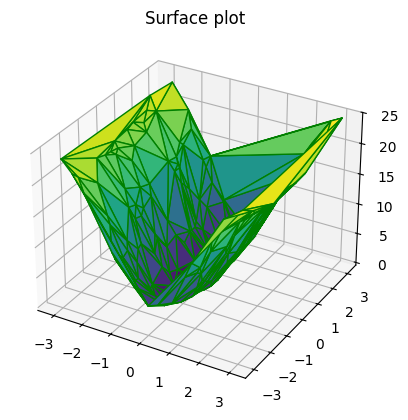

In [37]:
from matplotlib import pyplot as plt
fig = plt.figure()
 
# syntax for 3-D plotting
ax = plt.axes(projection='3d')
 
# syntax for plotting
ax.plot_trisurf(x_plot, y_plot, evals, cmap='viridis',\
                edgecolor='green')
ax.set_title('Surface plot')
plt.show()

In [38]:
import plotly.graph_objects as go
import numpy as np

# Assuming your x_plot, y_plot, and evals are lists of 199 elements each
x_plot = np.array(x_plot)
y_plot = np.array(y_plot)
evals = np.array(evals)

fig = go.Figure(
    data=[go.Scatter3d(x=x_plot, y=y_plot, z=evals, mode='markers')]
)
fig.update_layout(
    title='True energy outputs against a trajectory',
    autosize=False,
    width=500,
    height=500,
    margin=dict(l=65, r=50, b=65, t=90),
    scene_aspectmode='cube'
)
fig.show()
